Install the requirements and log in to huggingface with an access token.

In [1]:
!pip install -q --upgrade transformers diffusers ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.0/852.0 kB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.3 MB/s eta 0:00:00


In [ ]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16, use_auth_token=True).to("cuda")
image = pipe("An astronaught scuba diving").images[0]

In the first step, without any modification, we use the user interface of the library itself to generate the desired image for us. Next, we will apply the desired changes.

In [14]:
image = pipe("Dictators of the world in one person").images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

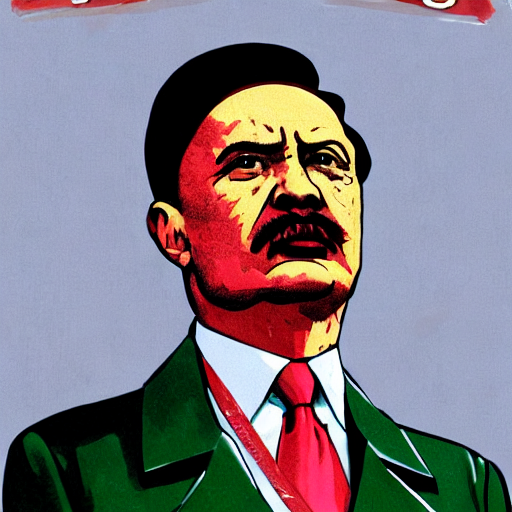

In [15]:
image

**Loading the models**


In this section, we load the models and components we need.
Here we have an auto [encoder](https://huggingface.co/CompVis/stable-diffusion-v1-4) to decode the latent to the main image space.
to [CLIP](https://huggingface.co/transformers/v4.8.0/model_doc/clip.html) as a model to Tonkenize and encode text.
to UNET for latent production
And finally to the scheduler to generate noise

In [ ]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

<ipython-input-17-a8e6ce23be29>:27: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

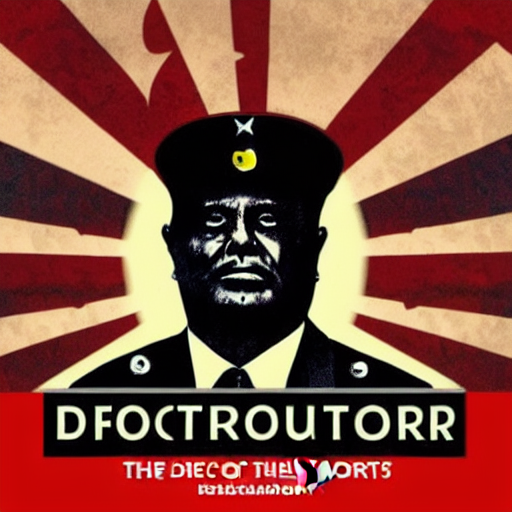

In [17]:
# Some settings
prompt = ["Dictators of the world in one person"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text 
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

# Loop
with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        # Scale the latents (preconditioning):
        # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
        latents = scheduler.step(noise_pred, t, latents).prev_sample

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

**The Auto Encoder**

At this stage, an image can be encoded and presented as Latent, and then the Latent can be decoded and returned to the original image.

In [18]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [19]:
# Download a demo Image
!curl --output Hitler.jpg 'https://thumbs.dreamstime.com/z/adolf-hitler-wax-statue-madame-tussaud-s-wax-museum-london-64090641.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  121k  100  121k    0     0  1182k      0 --:--:-- --:--:-- --:--:-- 1182k


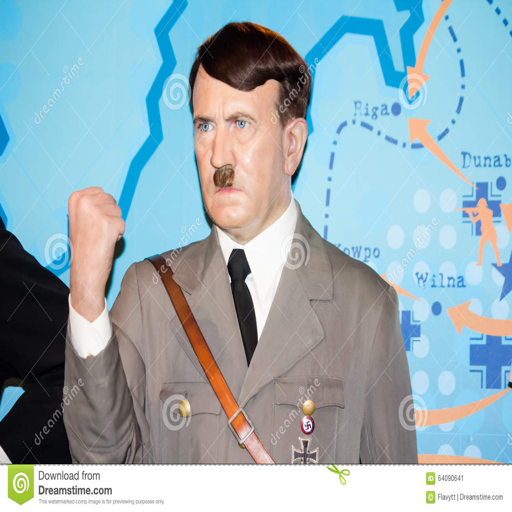

In [20]:
# Load the image with PIL
input_image = Image.open('Hitler.jpg').resize((512, 512))
input_image

In [21]:
# Encode to the latent space
encoded = pil_to_latent(input_image)
encoded.shape

torch.Size([1, 4, 64, 64])

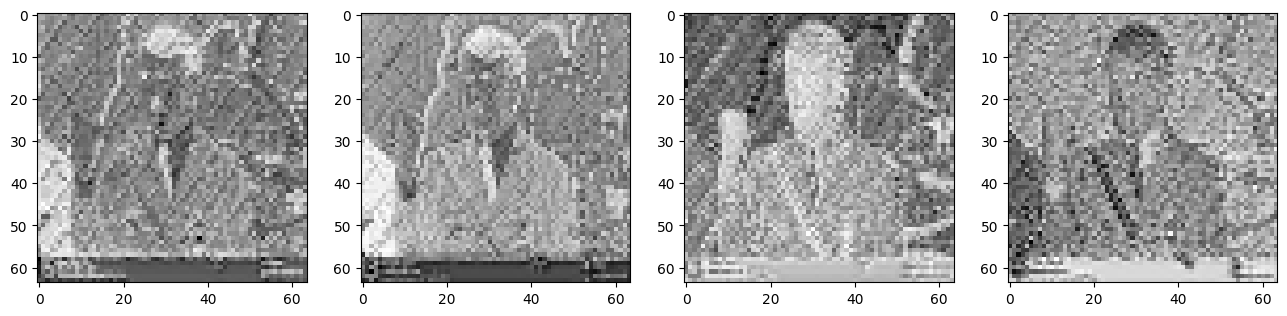

In [22]:
# Let's visualize the four channels of this latent representation:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(encoded[0][c].cpu(), cmap='Greys')

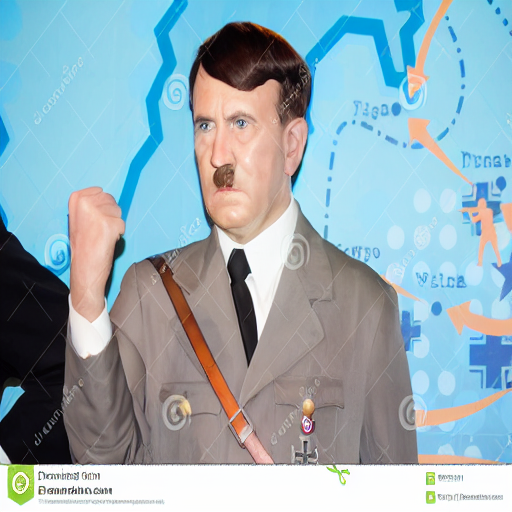

In [23]:
# Decode this latent representation back into an image
decoded = latents_to_pil(encoded)[0]
decoded

**The Scheduler**

During training, we add some noise to an image an then have the model try to predict the noise. If we always added a ton of noise, the model might not have much to work with. If we only add a tiny amount, the model won't be able to do much with the random starting points we use for sampling. So during training the amount is varied, according to some distribution.

During sampling, we want to 'denoise' over a number of steps. How many steps and how much noise we should aim for at each step are going to affect the final result.

The scheduler is in charge of handling all of these details. For example: scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000) sets up a scheduler that matches the one used to train this model. When we want to sample over a smaller number of steps, we set this up with scheduler.set_timesteps:

In [24]:
# Setting the number of sampling steps:
scheduler.set_timesteps(20)

In [25]:
# See these in terms of the original 1000 steps used for training:
print(scheduler.timesteps)

tensor([999.0000, 946.4211, 893.8421, 841.2632, 788.6842, 736.1053, 683.5263,
        630.9474, 578.3684, 525.7895, 473.2105, 420.6316, 368.0526, 315.4737,
        262.8947, 210.3158, 157.7368, 105.1579,  52.5789,   0.0000],
       dtype=torch.float64)


In [26]:
# Look at the equivalent noise levels:
print(scheduler.sigmas)

tensor([14.6146, 10.7468,  8.0815,  6.2050,  4.8557,  3.8654,  3.1238,  2.5572,
         2.1157,  1.7648,  1.4806,  1.2458,  1.0481,  0.8784,  0.7297,  0.5964,
         0.4736,  0.3555,  0.2322,  0.0292,  0.0000])


During sampling, we'll start at a high noise level (in fact, our input will be pure noise) and gradually 'denoise' down to an image, according to this schedule.

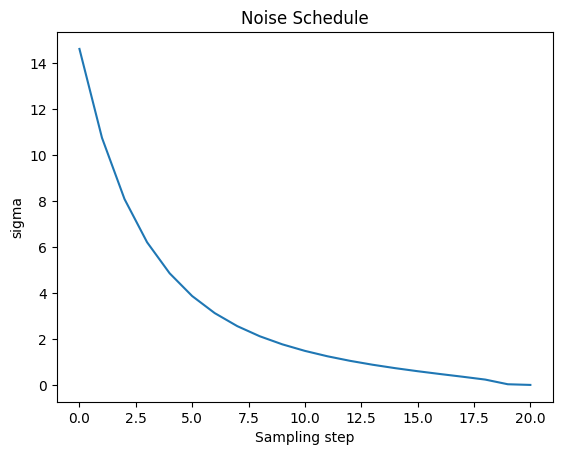

In [27]:
# Plotting this noise schedule:
plt.plot(scheduler.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Sampling step')
plt.ylabel('sigma')
plt.show()

This 'sigma' is the amount of noise added to the latent representation. Let's visualize what this looks like by adding a bit of noise to our encoded image and then decoding this noised version:

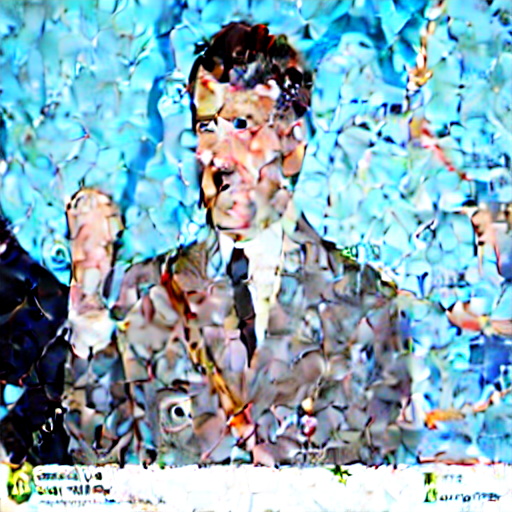

In [29]:
noise = torch.randn_like(encoded) # Random noise
sampling_step = 15 # Equivalent to step 10 out of 15 in the schedule above
# encoded_and_noised = scheduler.add_noise(encoded, noise, timestep) # Diffusers 0.3 and below
encoded_and_noised = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[sampling_step]]))
latents_to_pil(encoded_and_noised.float())[0] # Display

We'll use a similar loop to the first demo, but we'll skip the first start_step steps.

To noise our image we'll use code like that shown above, using the scheduler to noise it to a level equivalent to step 10 (start_step).

0it [00:00, ?it/s]

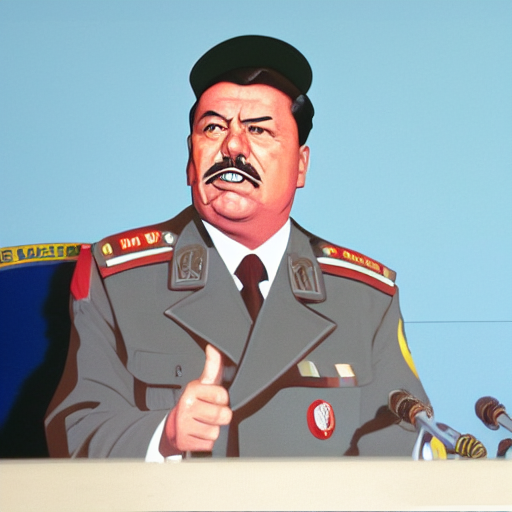

In [31]:
# Settings (same as before except for the new prompt)
prompt = ["Dictators of the world in one person, real photo"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50            # Number of denoising steps
guidance_scale = 8                  # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text (same as before)
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler (setting the number of inference steps)
scheduler.set_timesteps(num_inference_steps)

# Prep latents (noising appropriately for start_step)
start_step = 10
start_sigma = scheduler.sigmas[start_step]
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
latents = latents.to(torch_device).float()

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    if i >= start_step: # << This is the only modification to the loop we do
        
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

latents_to_pil(latents)[0]

**Exploring the text -> embedding pipeline**

We use a text encoder model to turn our text into a set of 'embeddings' which are fed to the diffusion model as conditioning. Let's follow a piece of text through this process and see how it works.

In [32]:
# Our text prompt
prompt = 'Dictators of the world in one person'

**tokenization:**

In [33]:
# Turn the text into a sequnce of tokens:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input['input_ids'][0] # View the tokens

tensor([49406, 26156,  1127,   539,   518,  1002,   530,   637,  2533, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])

See the individual tokens

In [35]:
for t in text_input['input_ids'][0][:10]: # We'll just look at the first 7 to save you from a wall of '<|endoftext|>'
    print(t, tokenizer.decoder.get(int(t)))

tensor(49406) <|startoftext|>
tensor(26156) dictat
tensor(1127) ors</w>
tensor(539) of</w>
tensor(518) the</w>
tensor(1002) world</w>
tensor(530) in</w>
tensor(637) one</w>
tensor(2533) person</w>
tensor(49407) <|endoftext|>


We pass our tokens through the text_encoder and we magically get some numbers we can feed to the model.

How are these generated? The tokens are transformed into a set of input embeddings, which are then fed through the transformer model to get the final output embeddings.

To get these input embeddings, there are actually two steps - as revealed by inspecting text_encoder.text_model.embeddings:

In [36]:
# Grab the output embeddings
output_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
print('Shape:', output_embeddings.shape)
output_embeddings

Shape: torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.9496,  0.2238, -0.3185,  ..., -1.3306,  0.1352,  0.6287],
         [-0.9541, -0.8424,  0.2243,  ..., -1.0494, -0.2184,  1.0464],
         ...,
         [-0.4416,  1.0154, -0.8825,  ..., -0.5688, -0.4161,  0.1214],
         [-0.4179,  1.0099, -0.8895,  ..., -0.5553, -0.3951,  0.1325],
         [-0.3880,  0.9875, -0.7767,  ..., -0.5409, -0.3716,  0.0794]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

**Token embeddings**

The token is fed to the token_embedding to transform it into a vector. The function name get_input_embeddings here is misleading since these token embeddings need to be combined with the position embeddings before they are actually used as inputs to the model!

In [38]:
# Access the embedding layer
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
token_emb_layer # Vocab size 49408, emb_dim 768

Embedding(49408, 768)

In [39]:
# Embed a token - in this case the one for 'Hitler'
embedding = token_emb_layer(torch.tensor(26156, device=torch_device))
embedding.shape # 768-dim representation

torch.Size([768])

We can do the same with all of the tokens in the prompt to get all the token embeddings:

In [40]:
token_embeddings = token_emb_layer(text_input.input_ids.to(torch_device))
print(token_embeddings.shape) # batch size 1, 77 tokens, 768 values for each
token_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0011,  0.0032,  0.0003,  ..., -0.0018,  0.0003,  0.0019],
         [ 0.0071, -0.0211,  0.0115,  ..., -0.0029, -0.0168, -0.0140],
         [-0.0082, -0.0136, -0.0026,  ...,  0.0207,  0.0327, -0.0149],
         ...,
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

**Positional Embeddings:**

Positional embeddings tell the model where in a sequence a token is. Much like the token embedding, this is a set of (optionally learnable) parameters. But now instead of dealing with ~50k tokens we just need one for each position (77 total):

In [41]:
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
pos_emb_layer

Embedding(77, 768)

We can get the positional embedding for each position

In [42]:
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)
print(position_embeddings.shape)
position_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0016,  0.0020,  0.0002,  ..., -0.0013,  0.0008,  0.0015],
         [ 0.0042,  0.0029,  0.0002,  ...,  0.0010,  0.0015, -0.0012],
         [ 0.0018,  0.0007, -0.0012,  ..., -0.0029, -0.0009,  0.0026],
         ...,
         [ 0.0216,  0.0055, -0.0101,  ..., -0.0065, -0.0029,  0.0037],
         [ 0.0188,  0.0073, -0.0077,  ..., -0.0025, -0.0009,  0.0057],
         [ 0.0330,  0.0281,  0.0289,  ...,  0.0160,  0.0102, -0.0310]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

**Combining token and position embeddings**

In [43]:
input_embeddings = token_embeddings + position_embeddings
print(input_embeddings.shape)
input_embeddings

torch.Size([1, 77, 768])


tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 1.1317e-02, -1.8261e-02,  1.1654e-02,  ..., -1.8853e-03,
          -1.5345e-02, -1.5172e-02],
         [-6.3373e-03, -1.2830e-02, -3.8173e-03,  ...,  1.7745e-02,
           3.1759e-02, -1.2371e-02],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)

# The following combines all the above steps (but doesn't let us fiddle with them!)

In [45]:
text_encoder.text_model.embeddings(text_input.input_ids.to(torch_device))

tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 1.1317e-02, -1.8261e-02,  1.1654e-02,  ..., -1.8853e-03,
          -1.5345e-02, -1.5172e-02],
         [-6.3373e-03, -1.2830e-02, -3.8173e-03,  ...,  1.7745e-02,
           3.1759e-02, -1.2371e-02],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)

We want to mess with these input embeddings (specifically the token embeddings) before we send them through the rest of the model, but first we should check that we know how to do that. I read the code of the text_encoders forward method, and based on that the code for the forward method of the text_model that the text_encoder wraps. To inspect it yourself, type ??text_encoder.text_model.forward and you'll get the function info and source code - a useful debugging trick!

Anyway, based on that we can copy in the bits we need to get the so-called 'last hidden state' and thus generate our final embeddings:

In [49]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True 
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

out_embs_test = get_output_embeds(input_embeddings) # Feed through the model with our new function
print(out_embs_test.shape) # Check the output shape
out_embs_test # Inspect the output

torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.9918,  0.6120, -0.6230,  ..., -0.9267, -0.2306,  0.2447],
         [-1.3859, -0.4450, -1.7522,  ...,  0.4238,  0.0047, -0.1549],
         ...,
         [-0.5869,  0.6820, -0.5579,  ..., -0.8084,  0.6181, -0.3689],
         [-0.5761,  0.6378, -0.5833,  ..., -0.7718,  0.6054, -0.3768],
         [-0.5349,  0.6536, -0.4621,  ..., -0.8930,  0.6199, -0.4200]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

Note that these match the output_embeddings we saw near the start - we've figured out how to split up that one step ("get the text embeddings") into multiple sub-steps ready for us to modify.

In [47]:
tst = 'Hitler'
tst_input = tokenizer(tst, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
for t in tst_input['input_ids'][0][:10]: # We'll just look at the first 7 to save you from a wall of '<|endoftext|>'
    print(t, tokenizer.decoder.get(int(t)))

tensor(49406) <|startoftext|>
tensor(16518) hitler</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


we can replace the input embedding of a token with a new one of our choice - which in our final use-case will be something we learn. To demonstrate the concept though, let's replace the input embedding for 'Hitler' in the prompt we've been playing with with the embedding for token 16518, get a new set of output embeddings based on this, and use these to generate an image to see what we get:

In [50]:
prompt = 'Dictators of the world in one person'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding. In this case just the input embedding of token 16518...
replacement_token_embedding = text_encoder.get_input_embeddings()(torch.tensor(16518, device=torch_device))

# Insert this into the token embeddings (
token_embeddings[0, torch.where(input_ids[0]==26156)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

print(modified_output_embeddings.shape)
modified_output_embeddings

torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.9918,  0.6120, -0.6230,  ..., -0.9267, -0.2306,  0.2447],
         [-1.3859, -0.4450, -1.7522,  ...,  0.4238,  0.0047, -0.1549],
         ...,
         [-0.5869,  0.6820, -0.5579,  ..., -0.8084,  0.6181, -0.3689],
         [-0.5761,  0.6378, -0.5833,  ..., -0.7718,  0.6054, -0.3768],
         [-0.5349,  0.6536, -0.4621,  ..., -0.8930,  0.6199, -0.4200]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

The first few are the same, the last aren't. Everything at and after the position of the token we're replacing will be affected.

If all went well, we should see something other than a puppy when we use these to generate an image. And sure enough, we do!

In [91]:
#Generating an image with these modified embeddings

def generate_with_embs(text_embeddings):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 40            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

<ipython-input-51-0fc356ceec5d>:24: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

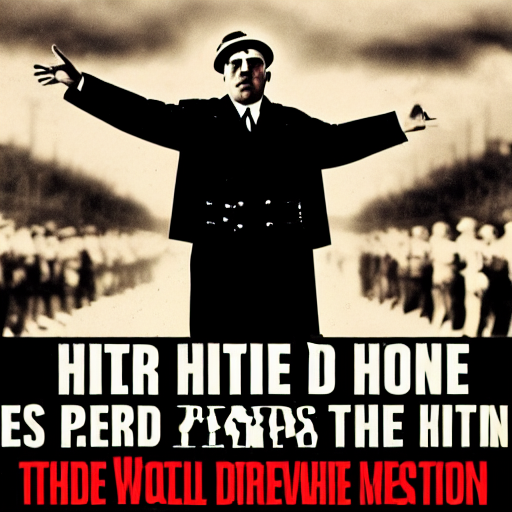

In [52]:
generate_with_embs(modified_output_embeddings)

And now, instead of token number 26156, which was related to the word dictator, token number 16518 was used and this image was produced!

In this step, instead of using one token, we want to use several tokens with different influence values to replace the dictator token:

In [71]:
tst = 'Hitler, Lenin, Putin'
tst_input = tokenizer(tst, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
for t in tst_input['input_ids'][0][:8]: # We'll just look at the first 7 to save you from a wall of '<|endoftext|>'
    print(t, tokenizer.decoder.get(int(t)))

tensor(49406) <|startoftext|>
tensor(16518) hitler</w>
tensor(267) ,</w>
tensor(41760) lenin</w>
tensor(267) ,</w>
tensor(10693) putin</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


<ipython-input-91-6a002d324cbb>:24: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

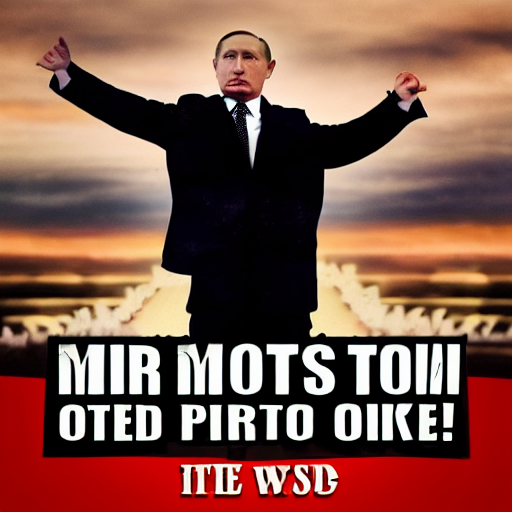

In [92]:
prompt = 'Dictators of the world in one person'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding. Which is now a mixture of the token embeddings for 'Hitler' ,'Lenin' and 'Putin'
hitler_token_embedding = token_emb_layer(torch.tensor(16518 , device=torch_device))
lenin_token_embedding = token_emb_layer(torch.tensor(41760, device=torch_device))
putin_token_embedding = token_emb_layer(torch.tensor(10693, device=torch_device))
replacement_token_embedding = 0.4*hitler_token_embedding + 0.1*lenin_token_embedding + 0.5*putin_token_embedding


# Insert this into the token embeddings (
token_embeddings[0, torch.where(input_ids[0]==26156)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# Generate an image with these
generate_with_embs(modified_output_embeddings)

The result is a picture of Hitler, Lenin and Putin combined. 

We used the  [moebius](https://huggingface.co/sd-concepts-library/moebius) style to produce images all in the style format.

In [82]:
birb_embed = torch.load('learned_embeds.bin')
birb_embed.keys(), birb_embed['<moebius>'].shape

(dict_keys(['<moebius>']), torch.Size([768]))

We get a dictionary with a key (the special placeholder I used, ) and the corresponding token embedding. As in the previous example, let's replace the 'puppy' token embedding with this and see what happens:

<ipython-input-88-6a29776c6b55>:24: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

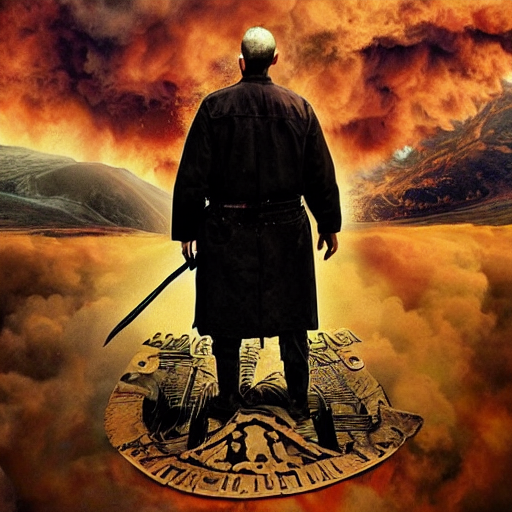

In [89]:
prompt = 'Dictators of the world in one person'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
style_tiken_embed = birb_embed['<moebius>'].to(torch_device)
# Mix them together
mix_factor = 0.4
mixed_embeddings = (hitler_token_embedding*mix_factor + putin_token_embedding*mix_factor +style_tiken_embed*(1-mix_factor))

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==26156)] = mixed_embeddings.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
generate_with_embs(modified_output_embeddings)

The token for 'Dictat' was replaced with one that captures a particular style of painting, but it could just as easily represent a specific object or class of objects.

Given a set of noisy latents, the model predicts the noise component. We can remove this noise from the noisy latents to see what the output image looks like (latents_x0 = latents - sigma * noise_pred). And we can add most of the noise back to this predicted output to get the (slightly less noisy hopefully) input for the next diffusion step. To visualize this let's generate another image, saving both the predicted output (x0) and the next step (xt-1) after every step:

In [111]:
prompt = 'Dictators of the world in one person'
height = 512                      
width = 512                        
num_inference_steps = 50
guidance_scale = 8.5    
generator = torch.manual_seed(42)
batch_size = 1

# Make a folder to store results
!rm -rf steps/
!mkdir -p steps/

# Prep text 
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
    
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
    


max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    # Get the predicted x0:
    # latents_x0 = latents - sigma * noise_pred # Calculating ourselves
    latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample # Using the scheduler (Diffusers 0.4 and above)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

    # To PIL Images
    im_t0 = latents_to_pil(latents_x0)[0]
    im_next = latents_to_pil(latents)[0]

    # Combine the two images and save for later viewing
    im = Image.new('RGB', (1024, 512))
    im.paste(im_next, (0, 0))
    im.paste(im_t0, (512, 0))
    im.save(f'steps/{i:04}.jpeg')

<ipython-input-111-013d34856735>:36: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

In [112]:
# Make and show the progress video (change width to 1024 for full res)
!ffmpeg -v 1 -y -f image2 -framerate 12 -i steps/%04d.jpeg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out.mp4
mp4 = open('out.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)